In [2]:
import numpy as np
import plotly
import json
import os
import plotly.express as px
import numpy as np
import statistics as st
import pandas as pd

def read_logs(log_path):
    '''
    read the log files and extract variable names
    '''
    with open(log_path, 'r') as f:
        data = json.load(f)
        #print(data)
    var = data.keys()   ### variables in the code
    return(var, data)

def cal_interval(time_list):
    '''
    time_list = list of timestamps each time the variable is executed
    return ->
        [exe interval] = list of execution intervals of consecutive executions
    '''
    interval_list = []
    for i in range(1,len(time_list)):
        prev_time = time_list[i-1]
        next_time = time_list[i]
        exe_inter = next_time - prev_time
        interval_list += [exe_inter]
        #print(i-1,i, exe_inter)
    return interval_list

def cal_feat(var_name, time_list):
    '''
    var_name = name of the variable
    time_list = list of timestamps each time the variable is executed
    return ->
        [features] = list of features for each variable
        [name, num of exe, mean exe inter, median, mode, [exe inter]]
    '''
    feature_fields = ['name', 'num_of_exe', 'mean_exe_inter', 'median', 'mode', 'exe_inter']
    var_features = []
    interval_mean = 0
    interval_median = 0
    interval_mode = 0
    
    #print(time_list)
    exe_num = len(time_list)
    if len(time_list) == 1:
        interval_list = [0]
    elif len(time_list) > 1:
        interval_list = cal_interval(time_list)
        interval_mean = st.mean(interval_list)
        interval_median = st.median(interval_list)
        interval_mode = st.mode(interval_list)
    
    var_features += [var_name]
    var_features += [exe_num]
    var_features += [interval_mean]
    var_features += [interval_median]
    var_features += [interval_mode]
    var_features += [interval_list]
    #print(var_features)
    return(var_features)

def prepare_to_write(features_list):
    '''
    write features to csv file
    prepare the data to write using pandas
    
    '''
    name = []
    num_of_exe = []
    mean_exe_inter = []
    median = []
    mode = []
    exe_inter = []
    for feat in features_list:
        #print(feat)
        name += [feat[0]]
        num_of_exe += [feat[1]]
        mean_exe_inter += [feat[2]]
        median += [feat[3]]
        mode += [feat[4]]
        exe_inter += [feat[5]]
        assert(len(name)==len(num_of_exe)==len(mean_exe_inter)==len(median)==len(mode)==len(exe_inter))
        
    feature_fields = ['name', 'num_of_exe', 'mean_exe_inter', 'median', 'mode', 'exe_inter']
    to_write = {
                feature_fields[0]:name,
               feature_fields[1]:num_of_exe,
               feature_fields[2]:mean_exe_inter,
               feature_fields[3]:median,
               feature_fields[4]:mode,
               feature_fields[5]:exe_inter
               }
    return(to_write)

def write_to_csv(data, name):
    '''
    data in dict format, where keys form the column names
    '''
    df = pd.DataFrame(data)
    df.to_csv(name+'.csv', index=False)


########### trace processing ##########
def read_traces(log_path):
    '''
    read the trace files and extract variable names
    '''
    with open(log_path, 'r') as f:
        data = json.load(f)
    return data

def generate_map(raw_trace):
    '''
    raw_trace -> list of event trace generated during logging
    return:
        event_map -> takes the variable name and gives corresponding event number
        event_remap -> takes event number and gives associated variable name
    '''
    unique_events = list(set(raw_trace))
    event_map = dict()
    event_remap = dict()
    for i in range(len(unique_events)):
        event_remap[i+1] = unique_events[i]
        event_map[unique_events[i]] = i+1

    return(event_map, event_remap)


### Input to select the scenario

In [1]:
############# configuration ################
############################################

code = 'theft_protection'       ### application (code)
behaviour = 'wrong_txinter'            ### normal, semantic_error
thread_typ = 'single'           ### single, multi
version = 2                     ### format of data collection

base_dir = '../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
log_path = base_dir+f'/{code}/{thread_typ}_thread/version_{version}/{behaviour}'

### Get paths to the files

In [3]:
######### file names
all_files = os.listdir(log_path)
all_files.sort()
logs = []
traces = []
unknown = []
for i in all_files:
    if i.find('log') == 0:
        logs += [i]
    elif i.find('trace') == 0:
        traces += [i]
    else:
        unknown += [i]

######### path to files
paths_log = [os.path.join(log_path, x) for x in logs]
paths_traces = [os.path.join(log_path, x) for x in traces]
paths_log.sort()

# Logs

### Calculate features for each log file and save it to csv file

In [4]:
###### input ######
select_file = -1
write_flag = True
###### input ######

In [5]:
######### calculate feature for each log file and save it to csv file #######
#############################################################################
## -1: all files, otherwise specify the index number

problem = []
if select_file == -1:
    for (p,w) in zip(paths_log, logs):
        try:
            var_list, data = read_logs(p)
        except:
            print(w,' not processed')
            problem += [w]
        list(var_list).sort()
        to_write_name = p.replace('trace_data', 'csv')

        ######### extract features
        features_list = []
        for var in var_list:
            features_list += [cal_feat(var, data[var])]
        ######### write data to csv
        isPath = os.path.exists(os.path.dirname(to_write_name)) ### check if the path exists
                ### create the folder if it does not exist
        if not isPath:
            os.makedirs(os.path.dirname(to_write_name))

        to_write = prepare_to_write(features_list)
        write_to_csv(to_write, to_write_name)
else:
    var_list, data = read_logs(paths_log[select_file])
    var_list = list(var_list)
    var_list.sort()
    to_write_name = paths_log[select_file].replace('trace_data', 'csv')

    ######### extract features
    features_list = []
    for var in var_list:
        #print(var)
        features = cal_feat(var, data[var])
        features_list += [features]
        #break

    if write_flag:
        ######### write data to csv
        isPath = os.path.exists(os.path.dirname(to_write_name)) ### check if the path exists
        ### create the folder if it does not exist
        if not isPath:
            os.makedirs(os.path.dirname(to_write_name))

        to_write = prepare_to_write(features_list)
        write_to_csv(to_write, to_write_name)

    

### Get range of exe time of each variable and look at data from all the logs wrt each variable


In [4]:
##### Get range of exe time of each variable and look at data from all the logs wrt each variable ######
########################################################################################################

col_names = []
analysis_data = dict() ### store data w.r.t the variable names
analysis_data['labels'] = [] ### name of the log files
analysis_min_max = dict() ### store data w.r.t the variable names
analysis_min_max['labels'] = [] ### name of the log files

### get the list of variables from all the log files
var_all = []
for p in paths_log:
    var_list, _ = read_logs(p)   ### data of each log file
    for v in var_list:
        if v not in var_all:
            var_all += [v]

### initialize the dict
for v in var_all:
    analysis_data[v] = []
    analysis_min_max[v] = []


### fill the dict with data
for (p,w) in zip(paths_log, logs):
    _, data = read_logs(p)   ### data of each log file
    #print(data)
    analysis_data['labels'] += [w]
    analysis_min_max['labels'] += [w]
    
    for v in var_all:
        try:
            features = cal_feat(v, data[v])
            #print(features)
            exe_time = features[5] ### get execution intervals
            exe_time = list(set(exe_time))
            analysis_data[v] += [exe_time]
            min_exe = min(exe_time) ### minimum exe time
            max_exe = max(exe_time) ### maximum exe time
            analysis_min_max[v] += [(min_exe, max_exe)]
        except:
            print(f'Variable {v} not found in file {w}')
        
        
write_to_csv(analysis_data, f'./exe_time/{thread_typ}_version{version}_exe_time_{behaviour}') 
write_to_csv(analysis_min_max, f'./min_max/{thread_typ}_version{version}_min_max_{behaviour}')    
    

### plot histogram 


### Get the execution plots

#### Log wise

In [8]:
############ prepare data to plot #############
###############################################

to_plot = []   ### in format -> [file_name, [[<exe inters of var 1>], [<exe inters of var 2>], .... ]]

### get the list of variables from all the log files
var_all = []
for p in paths_log:
    var_list, _ = read_logs(p)   ### data of each log file
    for v in var_list:
        if v not in var_all:
            var_all += [v]

### read files, iterate over file names and file paths
for (p,w) in zip(paths_log, logs):
    _, data = read_logs(p)   ### data of each log file
    xy_data = [] ### execution intervals
    var_names = []
    for v in var_all:
        try:
            time_list = data[v]   ### get the timestamps
            exe_time = []
            timestamp = []
            for (t1,t2) in zip(time_list[0:-1], time_list[1:]):
                tdiff = t2-t1
                #print(tdiff)
                exe_time+=[tdiff]
                timestamp+=[t2]
            assert(len(exe_time)==len(timestamp))
            var_names += [v]
            xy_data += [(exe_time,timestamp)]
        except:
            print(f'Variable {v} not found in file {w}')

    #break
    #print(w, len(xy_data[3][1]))
    assert(len(var_names)==len(xy_data))
    to_plot += [(p,var_names,xy_data)]   ### [name of the file to write plots, labels for legend (var names), execution intervals for respective variables(y_data), timestamps(x_data)]
    

[([1059, 1055, 1055, 1069, 1053, 1058, 1055, 1055, 1069, 1055, 1058, 1055, 1068, 1056, 1059, 1055, 1054, 1069, 1055, 1059, 1055, 1055, 1068, 1056, 1059, 1054, 1055, 1069, 1055, 1059, 1055, 1068, 1055, 1059, 1056, 1055, 1068, 1054, 1060, 1055, 1055, 1069, 1055, 1059, 1055, 1069, 1054, 1057, 1059, 1055, 1069, 1055, 1059, 1055, 1055, 1069, 1055, 1059, 1055, 1054, 1070, 1055, 1058, 1055, 1069, 1056, 1059, 1055, 1055, 1069, 1055, 1059, 1054, 1056, 1069, 1054, 1060, 1054, 1056, 1070, 1055, 1059, 1055, 1069, 1056, 1059, 1055, 1055, 1070, 1056, 1058, 1056, 1055, 1069], [9292, 10347, 11402, 12471, 13524, 14582, 15637, 16692, 17761, 18816, 19874, 20929, 21997, 23053, 24112, 25167, 26221, 27290, 28345, 29404, 30459, 31514, 32582, 33638, 34697, 35751, 36806, 37875, 38930, 39989, 41044, 42112, 43167, 44226, 45282, 46337, 47405, 48459, 49519, 50574, 51629, 52698, 53753, 54812, 55867, 56936, 57990, 59047, 60106, 61161, 62230, 63285, 64344, 65399, 66454, 67523, 68578, 69637, 70692, 71746, 72816, 73871

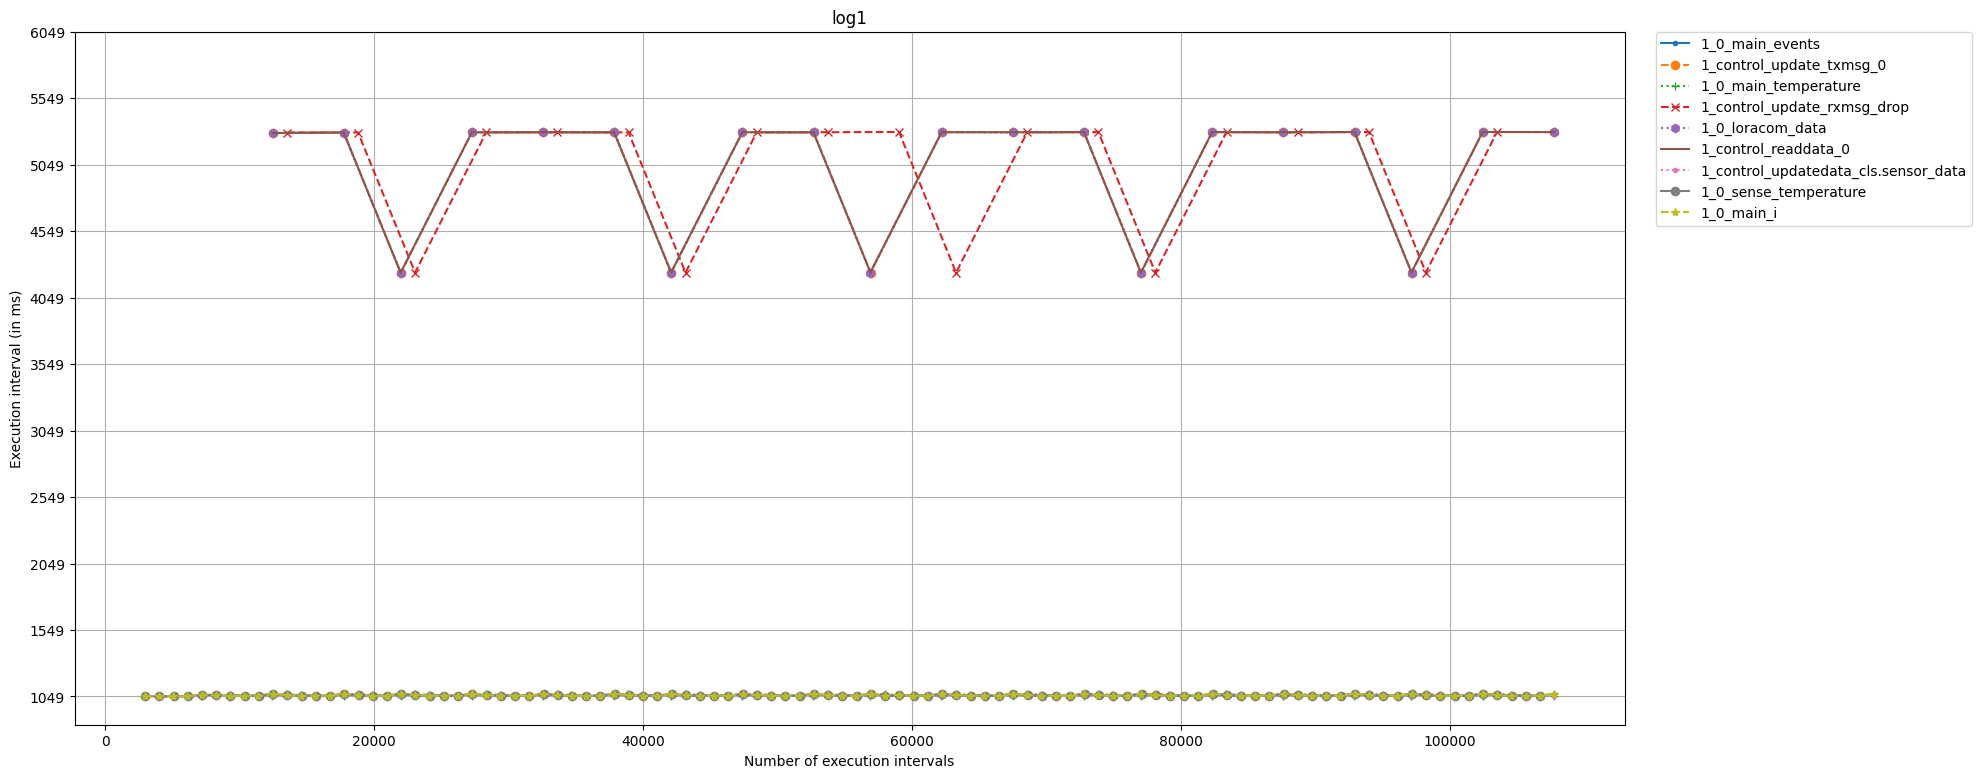

[([1060, 1054, 1054, 1069, 1055, 1058, 1056, 1055, 1069, 1054, 1059, 1054, 1070, 1054, 1059, 1055, 1055, 1069, 1055, 1059, 1055, 1055, 1068, 1056, 1058, 1055, 1054, 1070, 1055, 1060, 1055, 1068, 1056, 1059, 1054, 1056, 1069, 1054, 1060, 1054, 1056, 1069, 1055, 1060, 1056, 1068, 1055, 1055, 1056, 1055, 1069, 1054, 1059, 1056, 1055, 1068, 1056, 1058, 1056, 1056, 1069, 1055, 1058, 1055, 1069, 1056, 1058, 1055, 1056, 1069, 1056, 1059, 1055, 1055, 1069, 1055, 1060, 1054, 1056, 1069, 1055, 1059, 1055, 1069, 1055, 1060, 1055, 1055, 1070, 1056, 1058, 1056, 1056, 1069], [9288, 10342, 11396, 12465, 13520, 14578, 15634, 16689, 17758, 18812, 19871, 20925, 21995, 23049, 24108, 25163, 26218, 27287, 28342, 29401, 30456, 31511, 32579, 33635, 34693, 35748, 36802, 37872, 38927, 39987, 41042, 42110, 43166, 44225, 45279, 46335, 47404, 48458, 49518, 50572, 51628, 52697, 53752, 54812, 55868, 56936, 57991, 59046, 60102, 61157, 62226, 63280, 64339, 65395, 66450, 67518, 68574, 69632, 70688, 71744, 72813, 73868

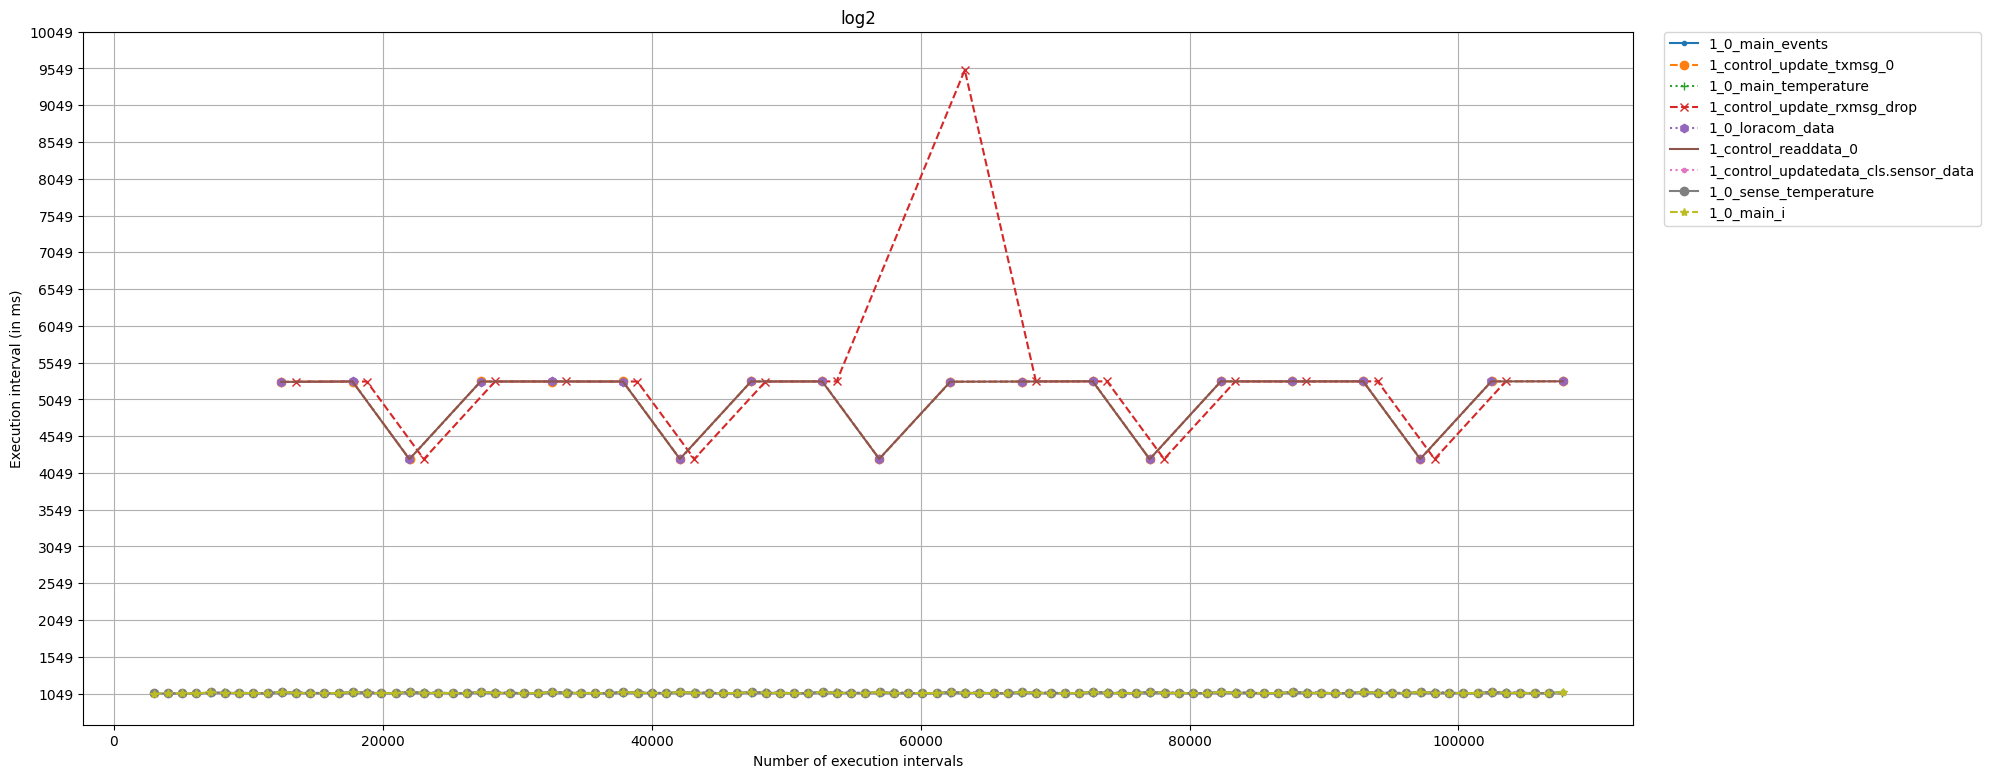

[([1060, 1055, 1054, 1070, 1054, 1058, 1055, 1054, 1069, 1056, 1058, 1055, 1070, 1055, 1059, 1055, 1054, 1066, 1055, 1058, 1055, 1055, 1068, 1055, 1060, 1054, 1054, 1070, 1055, 1059, 1056, 1068, 1055, 1060, 1055, 1055, 1069, 1054, 1060, 1055, 1055, 1069, 1055, 1060, 1055, 1068, 1054, 1060, 1055, 1055, 1068, 1055, 1059, 1056, 1055, 1068, 1055, 1058, 1056, 1055, 1069, 1054, 1060, 1055, 1069, 1056, 1058, 1056, 1055, 1068, 1056, 1058, 1055, 1054, 1070, 1055, 1058, 1055, 1056, 1069, 1055, 1058, 1054, 1070, 1055, 1059, 1056, 1055, 1069, 1056, 1058, 1055, 1055, 1069], [9268, 10323, 11377, 12447, 13501, 14559, 15614, 16668, 17737, 18793, 19851, 20906, 21976, 23031, 24090, 25145, 26199, 27265, 28320, 29378, 30433, 31488, 32556, 33611, 34671, 35725, 36779, 37849, 38904, 39963, 41019, 42087, 43142, 44202, 45257, 46312, 47381, 48435, 49495, 50550, 51605, 52674, 53729, 54789, 55844, 56912, 57966, 59026, 60081, 61136, 62204, 63259, 64318, 65374, 66429, 67497, 68552, 69610, 70666, 71721, 72790, 73844

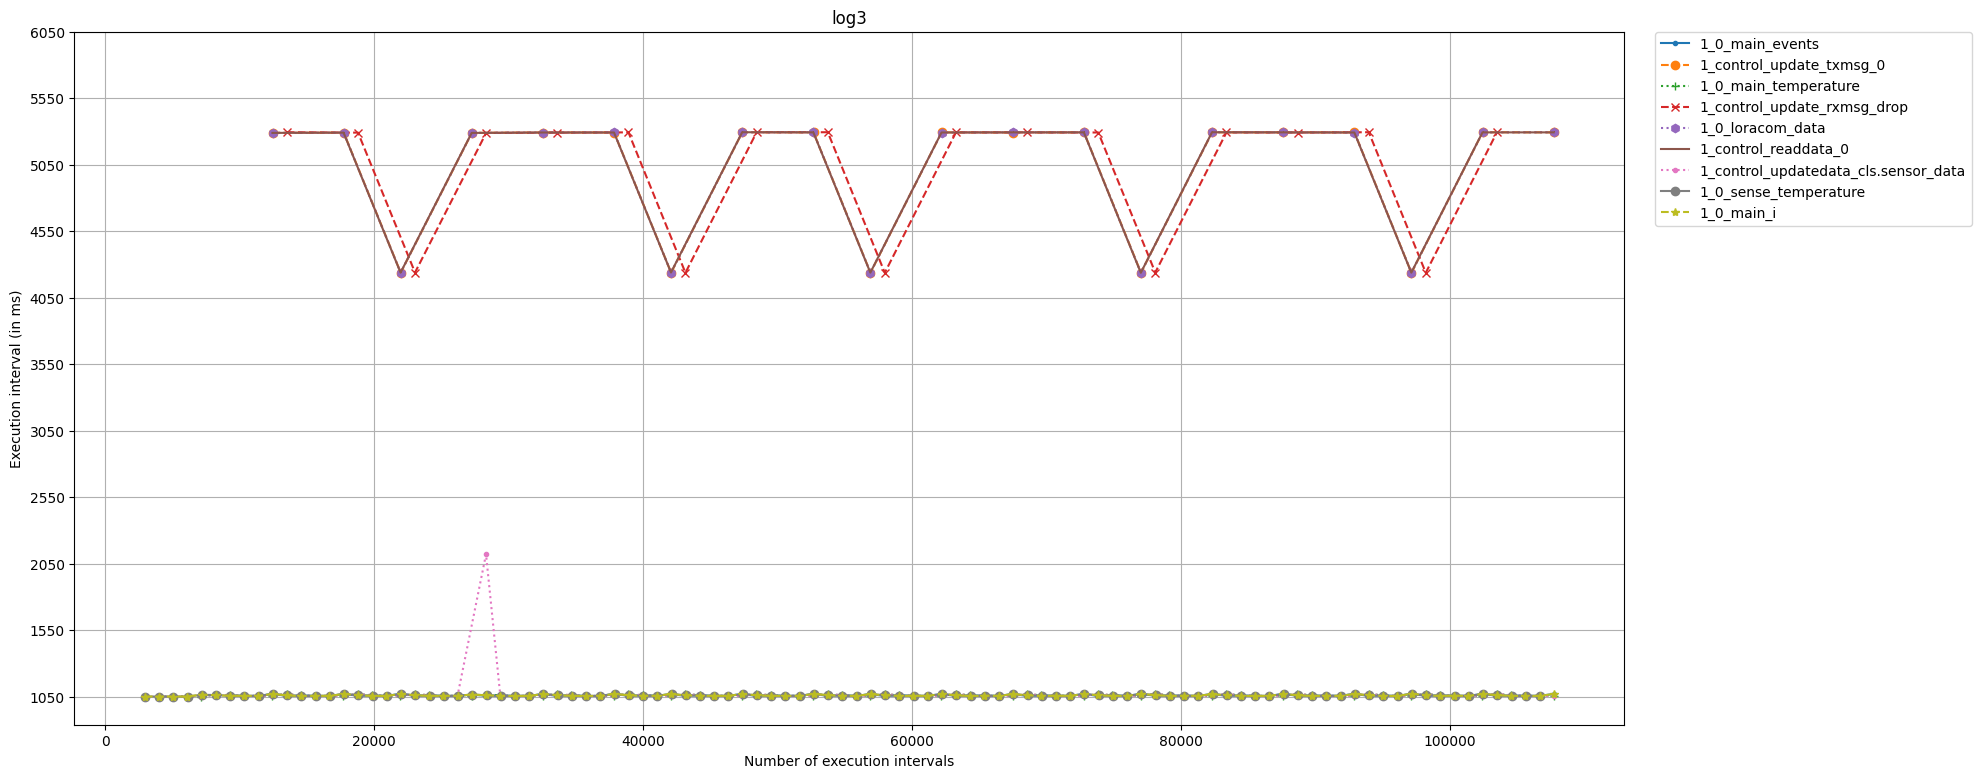

In [9]:
####### line plot for analysis
import matplotlib.pyplot as plt
import numpy as np

### var_names actually stand for variable names
for (name, var_names, xy_data) in to_plot:
    ### path to save the plots
    to_write_name = name.replace('trace_data', 'exe plots')
    file_name = os.path.basename(to_write_name)
    file_name = f'{thread_typ}_version{version}_{behaviour}_{file_name}'
    dir_name = os.path.dirname(to_write_name)
    to_write_name = os.path.join(dir_name, file_name)
    #print(to_write_name)
    isPath = os.path.exists(dir_name) ### check if the path exists
    ### create the folder if it does not exist
    if not isPath:
        os.makedirs(os.path.dirname(to_write_name))
    
    # print(name, var_names, y_data)
    max_len = 0
    ### get the max len of the longest list to resize all 
    for (v,xy) in zip(var_names, xy_data):
            if len(xy)>max_len:
                max_len=len(xy)

    # ### make all the list of same size to be able to plot
    # for (num, (v,xy)) in enumerate(zip(var_names, xy_data)):
    #     _y = np.zeros((max_len))
    #     for (n,i) in enumerate(xy):
    #         _y[n] = i
    #     #print(_y)
    #     y_data[num]=_y
    
    ########## make data frame to be able to plot ################
    df = dict()
    _y_all = [] ### to adjust y-ticks
    legend_lab = [] ### collect names of the plots only
    line_style = ['solid', 'dashed', 'dashdot', 'dotted']
    markers = ['.','o','*','+','^','x','d','h',',','H','D']
    fig = plt.figure(figsize =(20, 9))
    print(xy_data)
    for (num, (v,xy)) in enumerate(zip(var_names, xy_data)):
        x = xy[1]
        # x = [i-x[0] for i in x]   ### get timestamps relative to first timestamp
        y = xy[0]
        ### ignore all the variables that are only executed once
        if xy[1]!= []:
            #print(x,y)
            df[v]=xy
            _y_all.extend(y)
            legend_lab.append(v)
            
            plt.plot(x, y, ls=line_style[num%4], marker=markers[num%11])
    plt.legend(legend_lab, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #plt.xticks(np.arange(0, max_len+1, 2)) ### x-ticks every 2 intervals
    plt.yticks(np.arange(min(_y_all), max(_y_all)+1000, 500)) ### y ticks every 500ms
    plt.xlabel('Number of execution intervals')
    plt.ylabel('Execution interval (in ms)')
    plt.grid(True)
    plt.title(f'{os.path.basename(name)}')
    plt.savefig(f'{to_write_name}.png', bbox_inches='tight', transparent=False)
    plt.show()

    #break
#print(max_len)


#### Variable wise

In [10]:
############ prepare data to plot #############
###############################################

to_plot = []   ### in format -> [var_name, ( [[<exe inters of var in log1>], [timestamps ]  )]

### get the list of variables from all the log files
var_all = []
for p in paths_log:
    var_list, _ = read_logs(p)   ### data of each log file
    for v in var_list:
        if v not in var_all:
            var_all += [v]


### collect data for each variable from each log file
for v in var_all:
    xy_data = [] ### execution intervals
    log_names = []
    for (p,w) in zip(paths_log, logs):
        try:
            _, data = read_logs(p)   ### data of each log file
            time_list = data[v]   ### get the timestamps
            exe_time = []
            timestamp = []
            for (t1,t2) in zip(time_list[0:-1], time_list[1:]):
                tdiff = t2-t1
                #print(tdiff)
                exe_time+=[tdiff]
                timestamp+=[t2]
            assert(len(exe_time)==len(timestamp))
            log_names += [w]
            xy_data += [(exe_time,timestamp)]
        except Exception as e:
            print(e)

    assert(len(log_names)==len(xy_data))
    to_plot += [(p.replace(w,v),log_names,xy_data)]  ### [name of the file to write plots(variable name), labels for legend (log names), execution intervals for respective variables(y_data), timestamps(x_data)]



[([1059, 1055, 1055, 1069, 1053, 1058, 1055, 1055, 1069, 1055, 1058, 1055, 1068, 1056, 1059, 1055, 1054, 1069, 1055, 1059, 1055, 1055, 1068, 1056, 1059, 1054, 1055, 1069, 1055, 1059, 1055, 1068, 1055, 1059, 1056, 1055, 1068, 1054, 1060, 1055, 1055, 1069, 1055, 1059, 1055, 1069, 1054, 1057, 1059, 1055, 1069, 1055, 1059, 1055, 1055, 1069, 1055, 1059, 1055, 1054, 1070, 1055, 1058, 1055, 1069, 1056, 1059, 1055, 1055, 1069, 1055, 1059, 1054, 1056, 1069, 1054, 1060, 1054, 1056, 1070, 1055, 1059, 1055, 1069, 1056, 1059, 1055, 1055, 1070, 1056, 1058, 1056, 1055, 1069], [9292, 10347, 11402, 12471, 13524, 14582, 15637, 16692, 17761, 18816, 19874, 20929, 21997, 23053, 24112, 25167, 26221, 27290, 28345, 29404, 30459, 31514, 32582, 33638, 34697, 35751, 36806, 37875, 38930, 39989, 41044, 42112, 43167, 44226, 45282, 46337, 47405, 48459, 49519, 50574, 51629, 52698, 53753, 54812, 55867, 56936, 57990, 59047, 60106, 61161, 62230, 63285, 64344, 65399, 66454, 67523, 68578, 69637, 70692, 71746, 72816, 73871

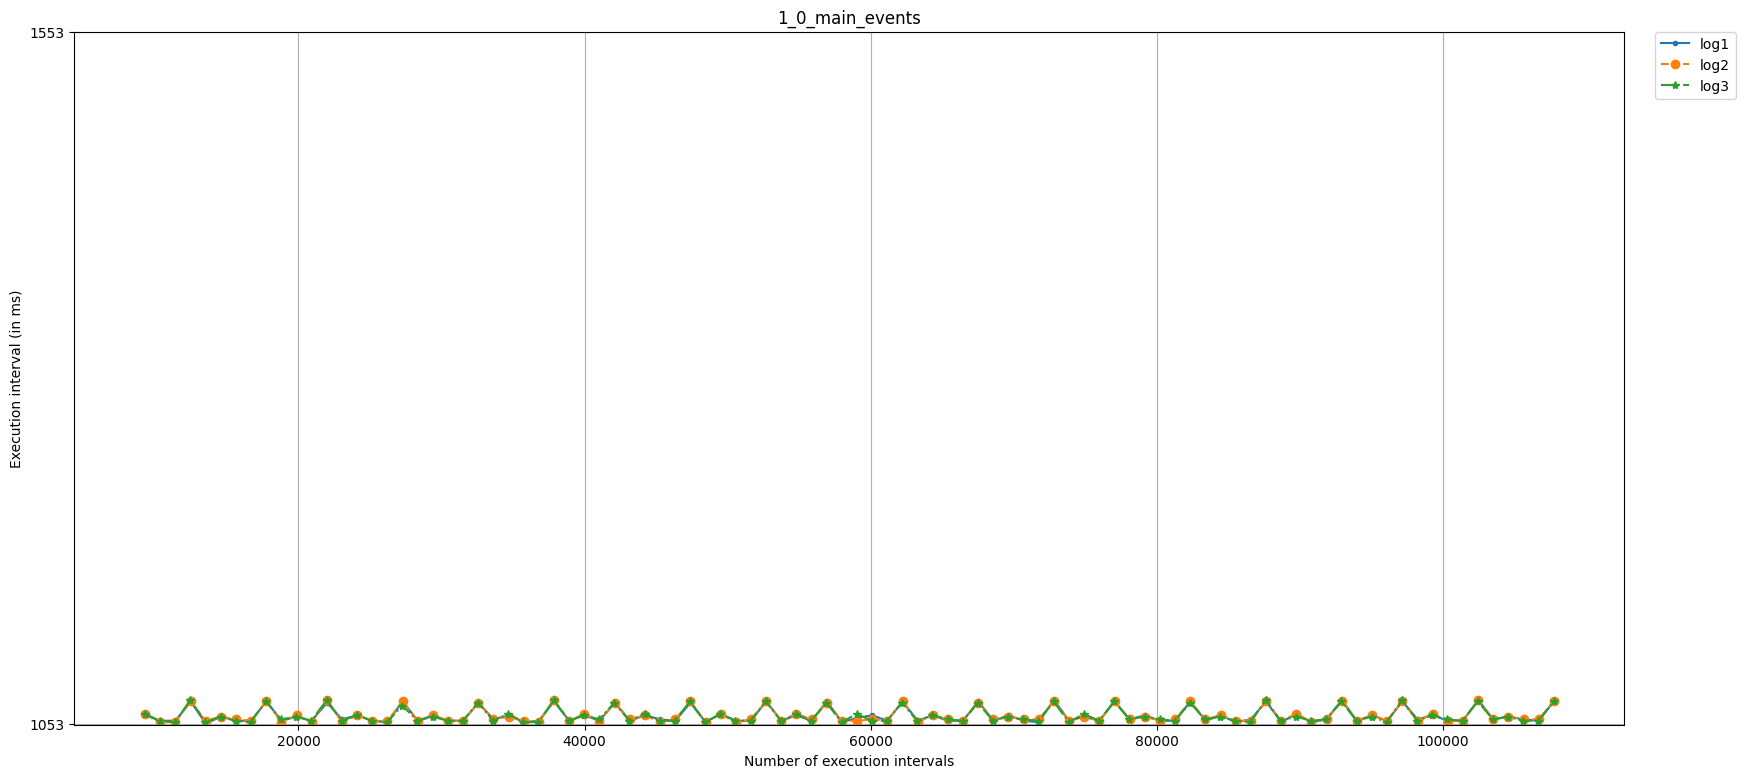

[([5287, 5291, 4236, 5293, 5292, 5293, 4237, 5293, 5293, 4238, 5294, 5293, 5293, 4237, 5294, 5293, 5294, 4238, 5295, 5294], [12465, 17756, 21992, 27285, 32577, 37870, 42107, 47400, 52693, 56931, 62225, 67518, 72811, 77048, 82342, 87635, 92929, 97167, 102462, 107756]), ([5288, 5292, 4236, 5293, 5292, 5293, 4238, 5293, 5294, 4240, 5289, 5292, 5295, 4237, 5294, 5294, 5294, 4238, 5295, 5295], [12461, 17753, 21989, 27282, 32574, 37867, 42105, 47398, 52692, 56932, 62221, 67513, 72808, 77045, 82339, 87633, 92927, 97165, 102460, 107755]), ([5290, 5291, 4238, 5289, 5292, 5292, 4238, 5294, 5293, 4238, 5293, 5292, 5293, 4238, 5293, 5293, 5293, 4237, 5294, 5293], [12442, 17733, 21971, 27260, 32552, 37844, 42082, 47376, 52669, 56907, 62200, 67492, 72785, 77023, 82316, 87609, 92902, 97139, 102433, 107726])]


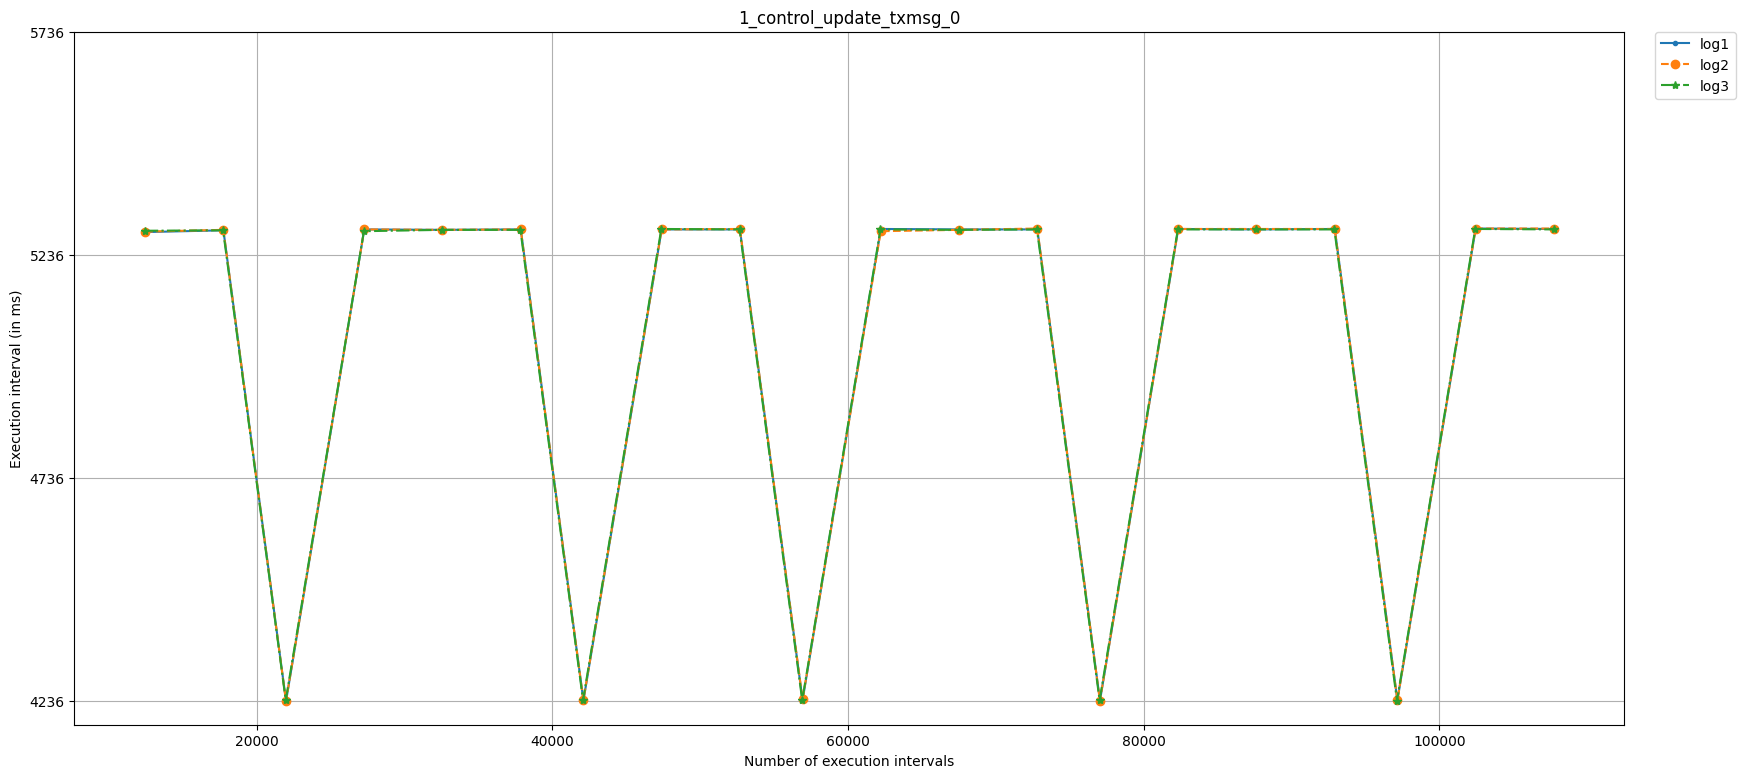

[([], []), ([], []), ([], [])]
[([1050, 1050, 1050, 1050, 1064, 1058, 1055, 1055, 1055, 1068, 1058, 1054, 1055, 1055, 1069, 1058, 1055, 1055, 1069, 1059, 1055, 1054, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1054, 1055, 1055, 1069, 1059, 1055, 1055, 1068, 1059, 1056, 1055, 1055, 1068, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1069, 1056, 1059, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1054, 1055, 1070, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1056, 1069, 1059, 1055, 1055, 1070, 1059, 1055, 1055, 1056, 1070, 1059, 1055, 1055, 1055], [4011, 5061, 6111, 7161, 8225, 9283, 10338, 11393, 12448, 13516, 14574, 15628, 16683, 17738, 18807, 19865, 20920, 21975, 23044, 24103, 25158, 26212, 27267, 28336, 29395, 30450, 31505, 32560, 33629, 34688, 35742, 36797, 37852, 38921, 39980, 41035, 42090, 43158, 44217, 45273, 46328, 47383, 48451, 49510, 50565, 51620, 52675, 53744, 54803, 55858, 56913, 57982, 59038, 60097

<Figure size 2000x900 with 0 Axes>

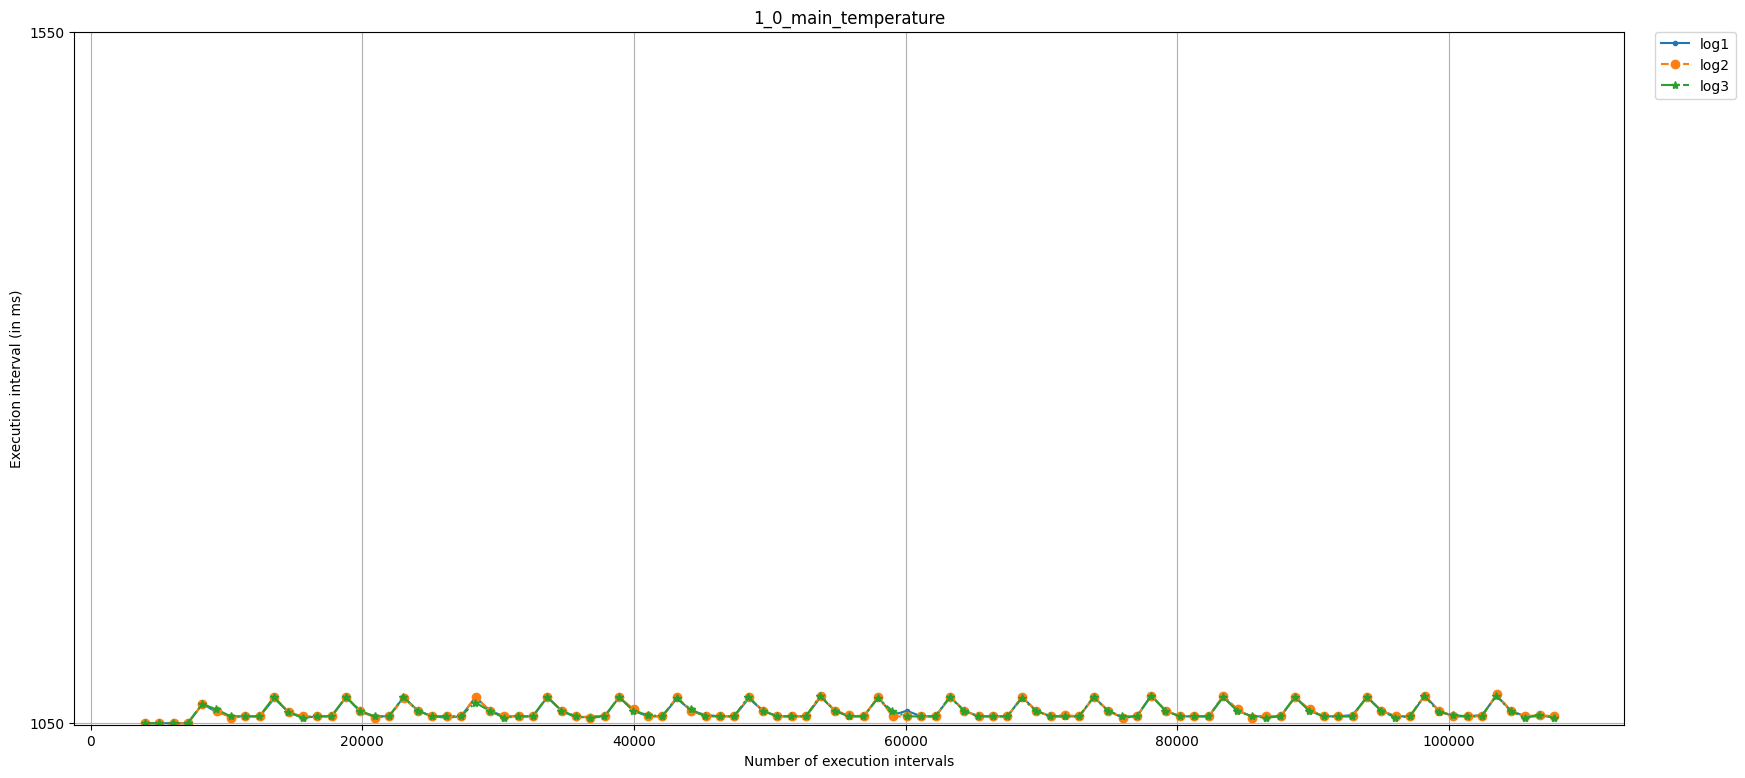

[([], []), ([], []), ([], [])]
[([5291, 5291, 4238, 5292, 5293, 5292, 4237, 5292, 5293, 5295, 4237, 5293, 5294, 4237, 5294, 5292, 5295, 4238, 5295], [13528, 18819, 23057, 28349, 33642, 38934, 43171, 48463, 53756, 59051, 63288, 68581, 73875, 78112, 83406, 88698, 93993, 98231, 103526]), ([5292, 5292, 4237, 5293, 5293, 5292, 4239, 5292, 5294, 9528, 5294, 5294, 4238, 5293, 5293, 5295, 4238, 5296], [13524, 18816, 23053, 28346, 33639, 38931, 43170, 48462, 53756, 63284, 68578, 73872, 78110, 83403, 88696, 93991, 98229, 103525]), ([5294, 5291, 4239, 5289, 5291, 5293, 4237, 5294, 5294, 4237, 5293, 5293, 5292, 4239, 5293, 5292, 5294, 4237, 5294], [13505, 18796, 23035, 28324, 33615, 38908, 43145, 48439, 53733, 57970, 63263, 68556, 73848, 78087, 83380, 88672, 93966, 98203, 103497])]


<Figure size 2000x900 with 0 Axes>

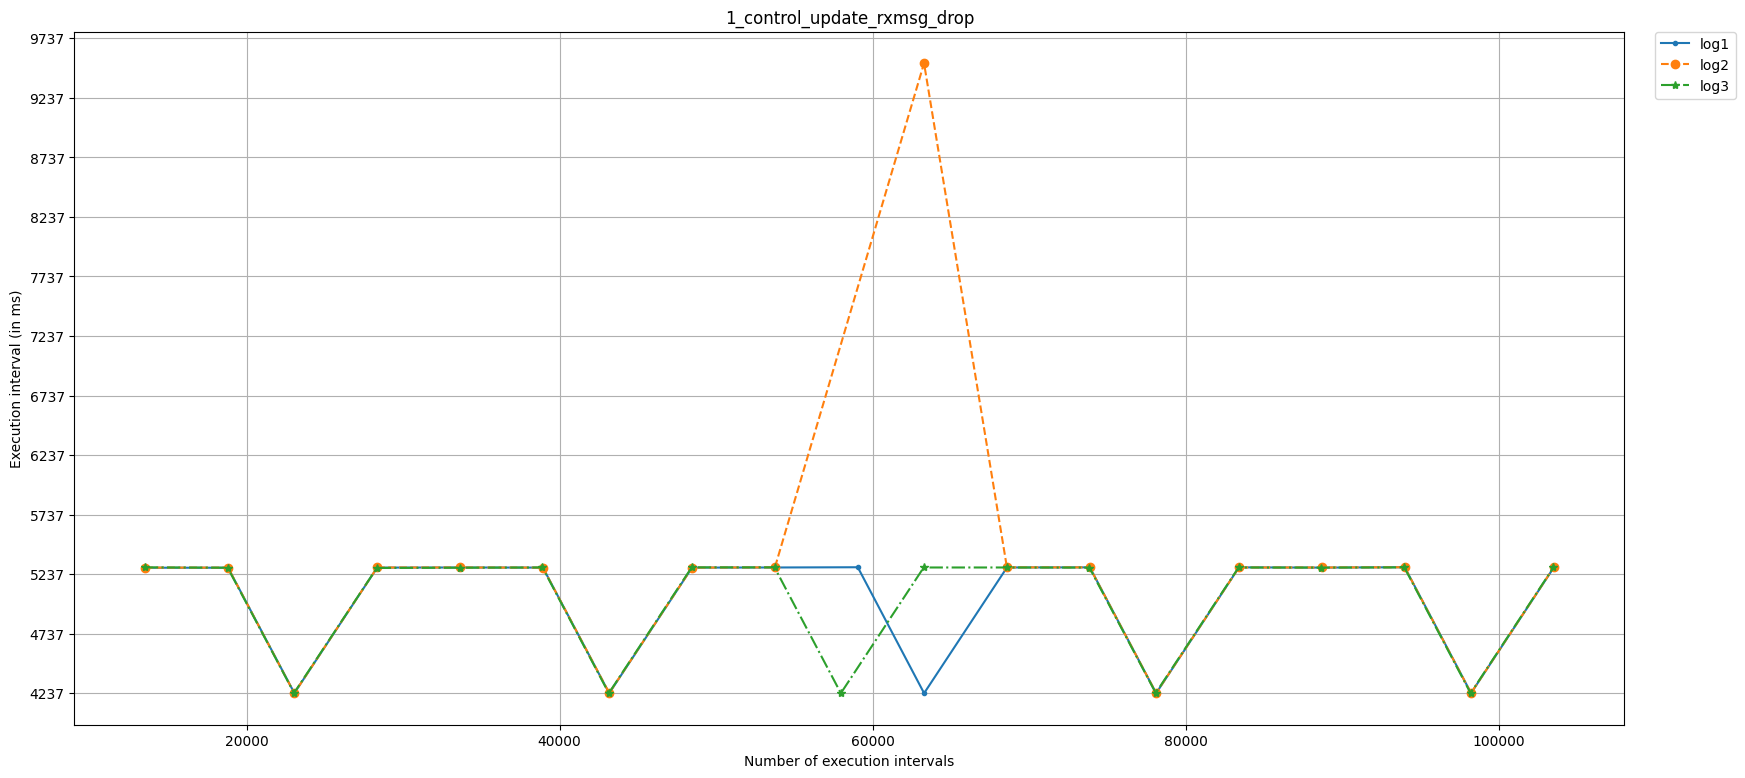

[([], []), ([], []), ([], [])]
[([5287, 5291, 4236, 5292, 5293, 5293, 4237, 5293, 5293, 4238, 5294, 5292, 5294, 4237, 5293, 5294, 5294, 4238, 5295, 5294], [12460, 17751, 21987, 27279, 32572, 37865, 42102, 47395, 52688, 56926, 62220, 67512, 72806, 77043, 82336, 87630, 92924, 97162, 102457, 107751]), ([5287, 5293, 4236, 5292, 5293, 5292, 4239, 5293, 5294, 4239, 5290, 5292, 5295, 4236, 5295, 5293, 5294, 4239, 5294, 5296], [12455, 17748, 21984, 27276, 32569, 37861, 42100, 47393, 52687, 56926, 62216, 67508, 72803, 77039, 82334, 87627, 92921, 97160, 102454, 107750]), ([5289, 5291, 4238, 5289, 5292, 5293, 4238, 5293, 5294, 4238, 5292, 5293, 5293, 4237, 5294, 5293, 5292, 4238, 5293, 5294], [12436, 17727, 21965, 27254, 32546, 37839, 42077, 47370, 52664, 56902, 62194, 67487, 72780, 77017, 82311, 87604, 92896, 97134, 102427, 107721])]


<Figure size 2000x900 with 0 Axes>

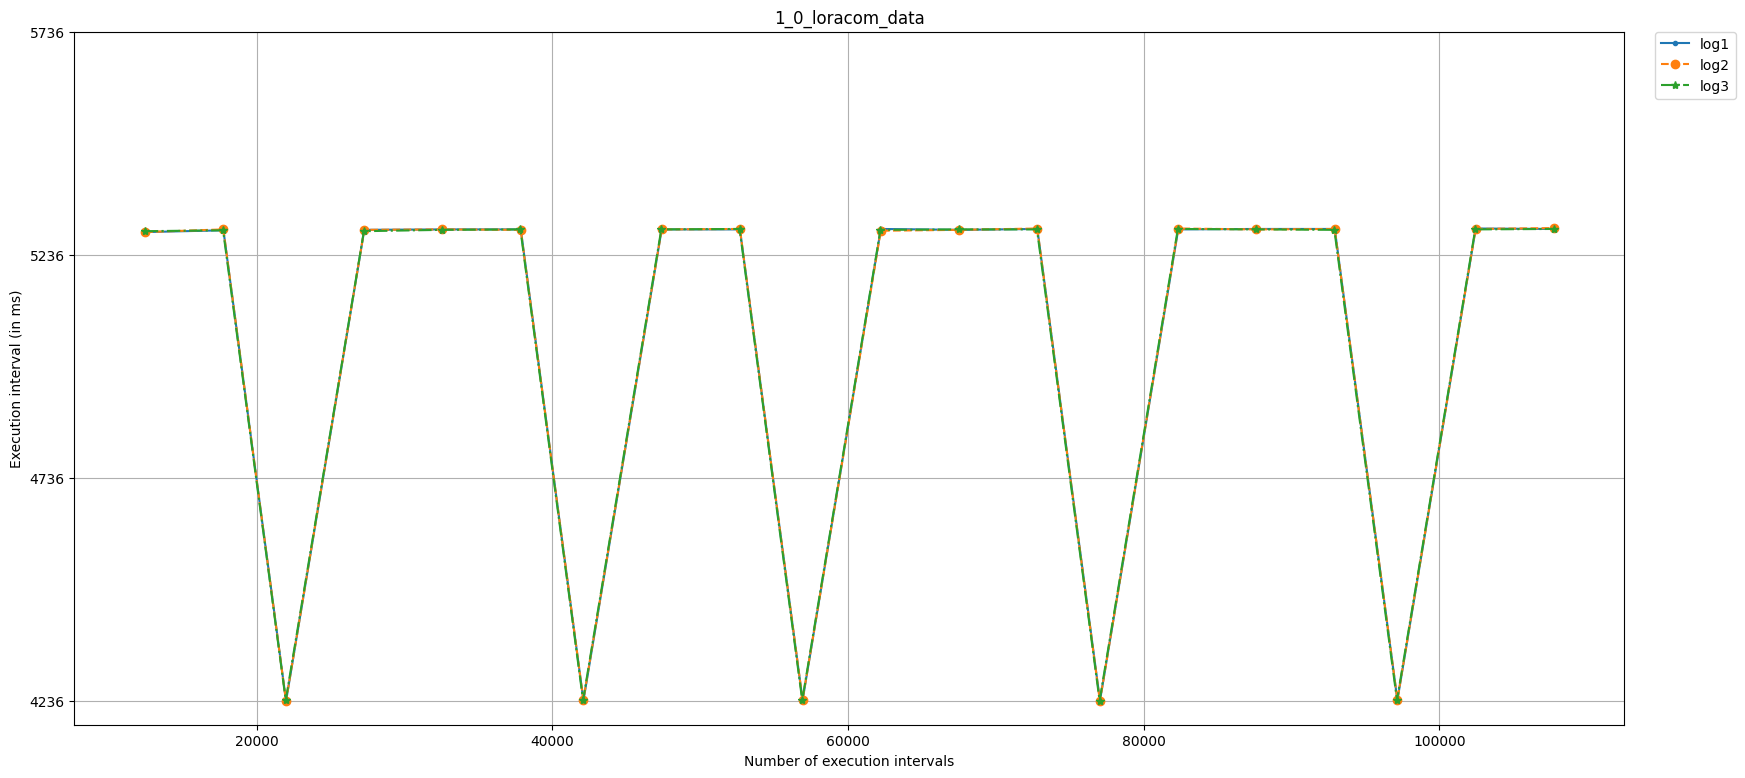

[([5287, 5291, 4236, 5292, 5293, 5292, 4238, 5293, 5292, 4239, 5293, 5293, 5294, 4236, 5294, 5293, 5295, 4238, 5295, 5294], [12455, 17746, 21982, 27274, 32567, 37859, 42097, 47390, 52682, 56921, 62214, 67507, 72801, 77037, 82331, 87624, 92919, 97157, 102452, 107746]), ([5287, 5293, 4236, 5292, 5293, 5292, 4239, 5293, 5293, 4240, 5290, 5292, 5295, 4236, 5294, 5294, 5294, 4239, 5294, 5295], [12450, 17743, 21979, 27271, 32564, 37856, 42095, 47388, 52681, 56921, 62211, 67503, 72798, 77034, 82328, 87622, 92916, 97155, 102449, 107744]), ([5289, 5291, 4238, 5289, 5292, 5292, 4239, 5294, 5293, 4238, 5292, 5293, 5293, 4237, 5294, 5293, 5292, 4238, 5293, 5293], [12431, 17722, 21960, 27249, 32541, 37833, 42072, 47366, 52659, 56897, 62189, 67482, 72775, 77012, 82306, 87599, 92891, 97129, 102422, 107715])]


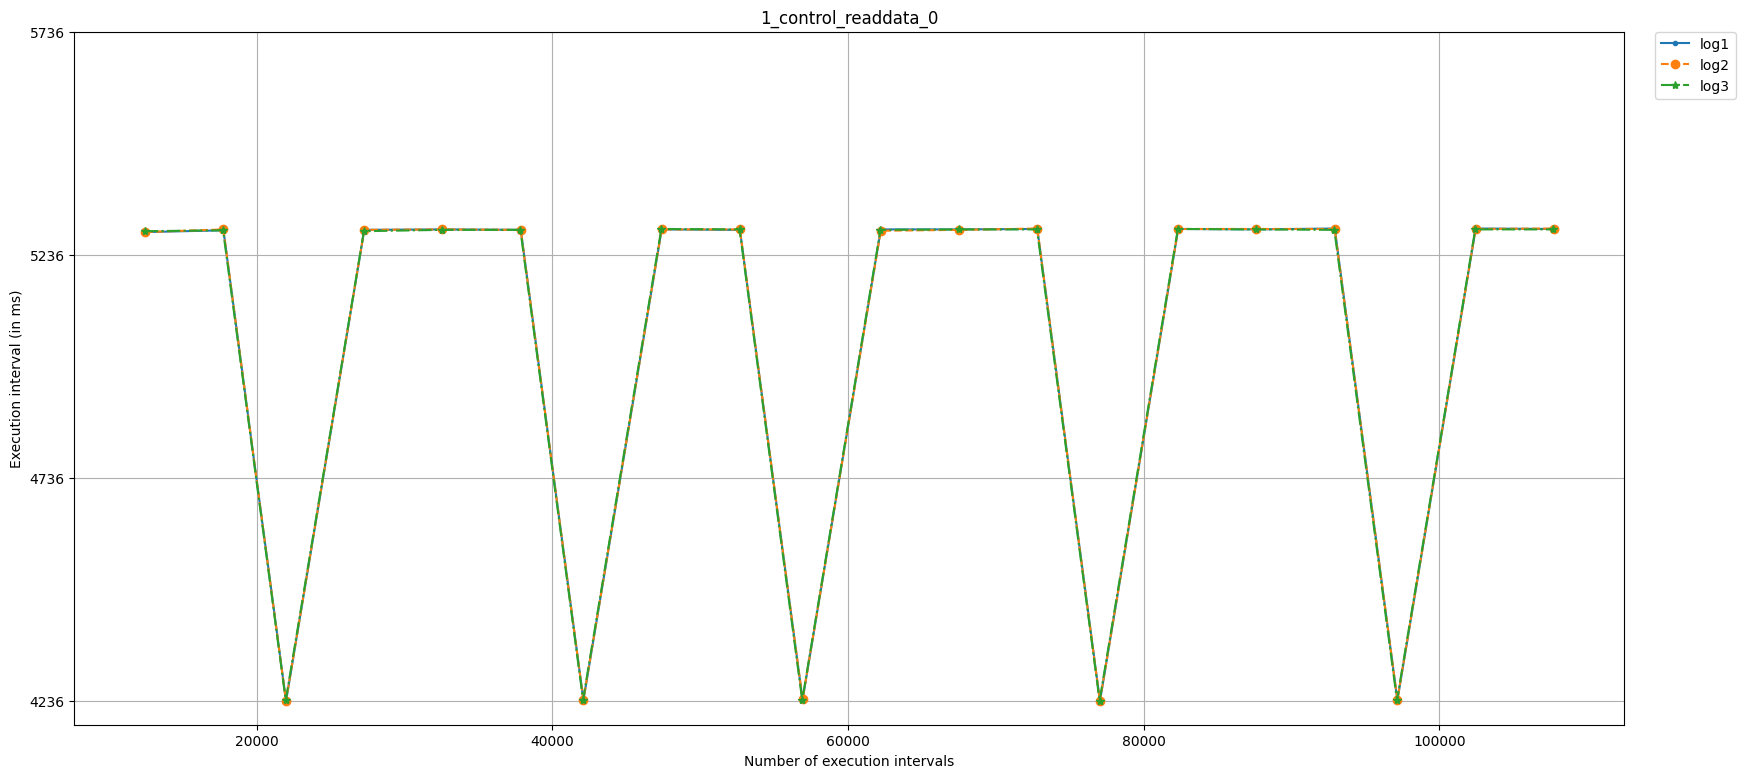

[([], []), ([], []), ([], [])]
[([], []), ([], []), ([], [])]
[([1050, 1050, 1050, 1050, 1064, 1058, 1055, 1055, 1055, 1068, 1058, 1054, 1055, 1055, 1069, 1058, 1055, 1055, 1069, 1059, 1055, 1054, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1054, 1055, 1055, 1069, 1059, 1055, 1055, 1068, 1059, 1056, 1055, 1055, 1068, 1060, 1054, 1055, 1055, 1069, 1059, 1055, 1055, 1069, 1056, 1059, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1054, 1070, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1056, 1069, 1059, 1055, 1055, 1070, 1059, 1055, 1056, 1055, 1070, 1059, 1055, 1055, 1055], [4015, 5065, 6115, 7165, 8229, 9287, 10342, 11397, 12452, 13520, 14578, 15632, 16687, 17742, 18811, 19869, 20924, 21979, 23048, 24107, 25162, 26216, 27271, 28340, 29399, 30454, 31509, 32564, 33633, 34692, 35746, 36801, 37856, 38925, 39984, 41039, 42094, 43162, 44221, 45277, 46332, 47387, 48455, 49515, 50569, 51624, 52679, 53748, 54807, 55

<Figure size 2000x900 with 0 Axes>

<Figure size 2000x900 with 0 Axes>

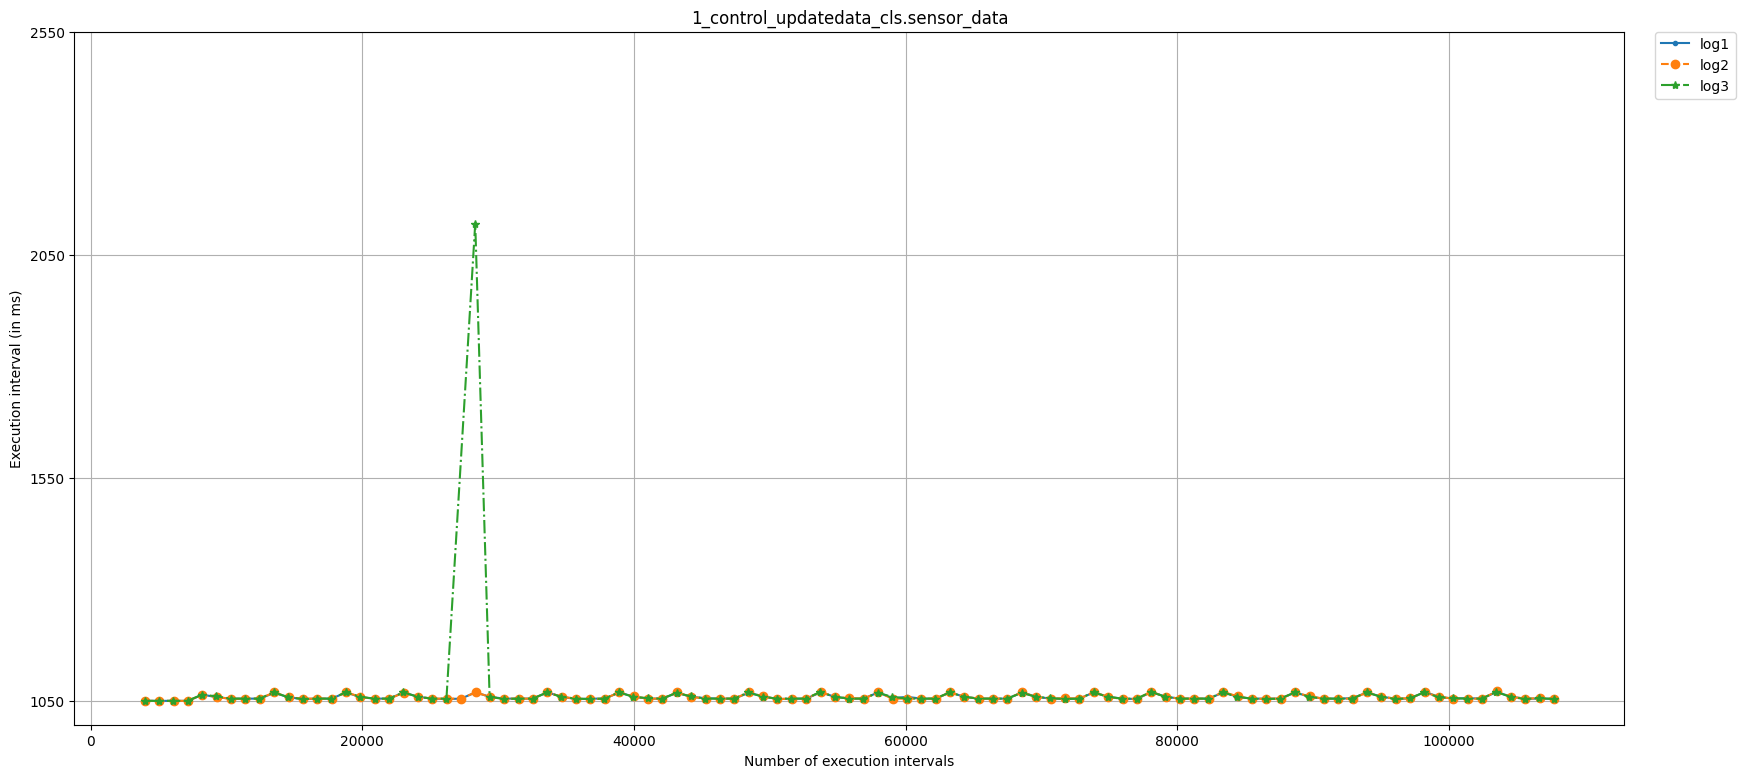

[([1050, 1050, 1050, 1050, 1064, 1059, 1054, 1055, 1055, 1069, 1057, 1055, 1054, 1055, 1069, 1059, 1053, 1056, 1069, 1059, 1055, 1055, 1054, 1069, 1059, 1055, 1055, 1055, 1069, 1060, 1054, 1054, 1055, 1069, 1059, 1055, 1055, 1068, 1059, 1055, 1056, 1055, 1068, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1069, 1056, 1059, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1054, 1055, 1070, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1056, 1069, 1059, 1055, 1055, 1070, 1059, 1055, 1055, 1056, 1070, 1059, 1055, 1055, 1055], [2994, 4044, 5094, 6144, 7208, 8267, 9321, 10376, 11431, 12500, 13557, 14612, 15666, 16721, 17790, 18849, 19902, 20958, 22027, 23086, 24141, 25196, 26250, 27319, 28378, 29433, 30488, 31543, 32612, 33672, 34726, 35780, 36835, 37904, 38963, 40018, 41073, 42141, 43200, 44255, 45311, 46366, 47434, 48493, 49548, 50603, 51658, 52727, 53786, 54841, 55896, 56965, 58021, 59080, 60135, 61190, 62259, 63318, 64

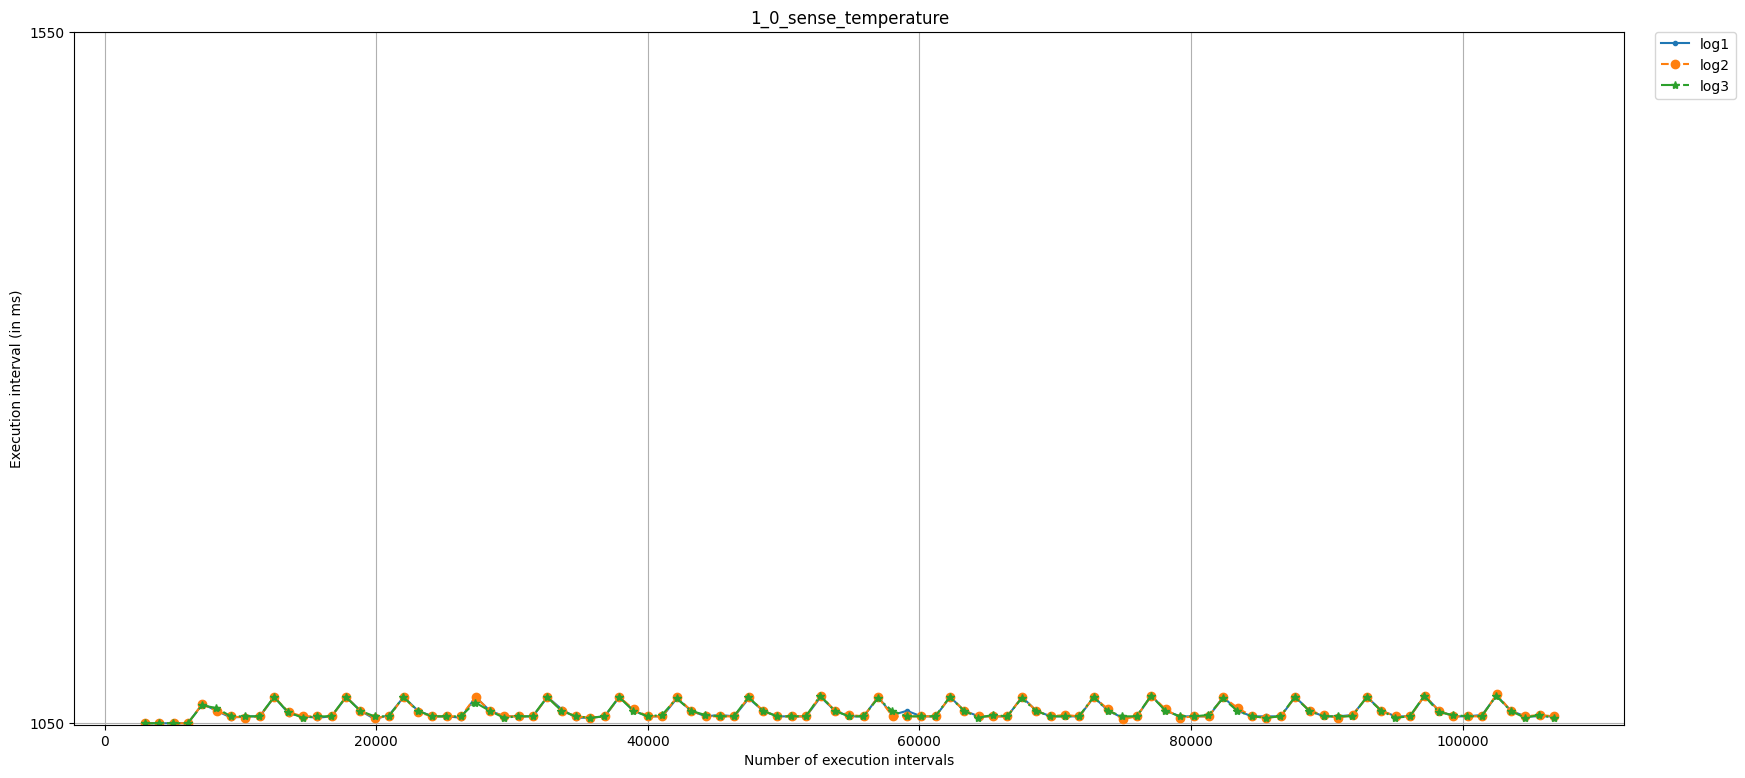

[([1049, 1050, 1050, 1050, 1064, 1059, 1054, 1055, 1055, 1069, 1058, 1054, 1054, 1055, 1069, 1059, 1054, 1055, 1068, 1060, 1055, 1055, 1054, 1069, 1059, 1055, 1055, 1055, 1068, 1060, 1055, 1054, 1055, 1069, 1059, 1055, 1055, 1068, 1059, 1055, 1056, 1055, 1068, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1069, 1055, 1060, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1054, 1055, 1070, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1069, 1059, 1055, 1055, 1055, 1070, 1059, 1055, 1055, 1069, 1060, 1055, 1055, 1055, 1071, 1059, 1055, 1055, 1055, 1069], [2969, 4019, 5069, 6119, 7183, 8242, 9296, 10351, 11406, 12475, 13533, 14587, 15641, 16696, 17765, 18824, 19878, 20933, 22001, 23061, 24116, 25171, 26225, 27294, 28353, 29408, 30463, 31518, 32586, 33646, 34701, 35755, 36810, 37879, 38938, 39993, 41048, 42116, 43175, 44230, 45286, 46341, 47409, 48468, 49523, 50578, 51633, 52702, 53761, 54816, 55871, 56940, 57995, 59055, 60110, 61165, 62234, 632

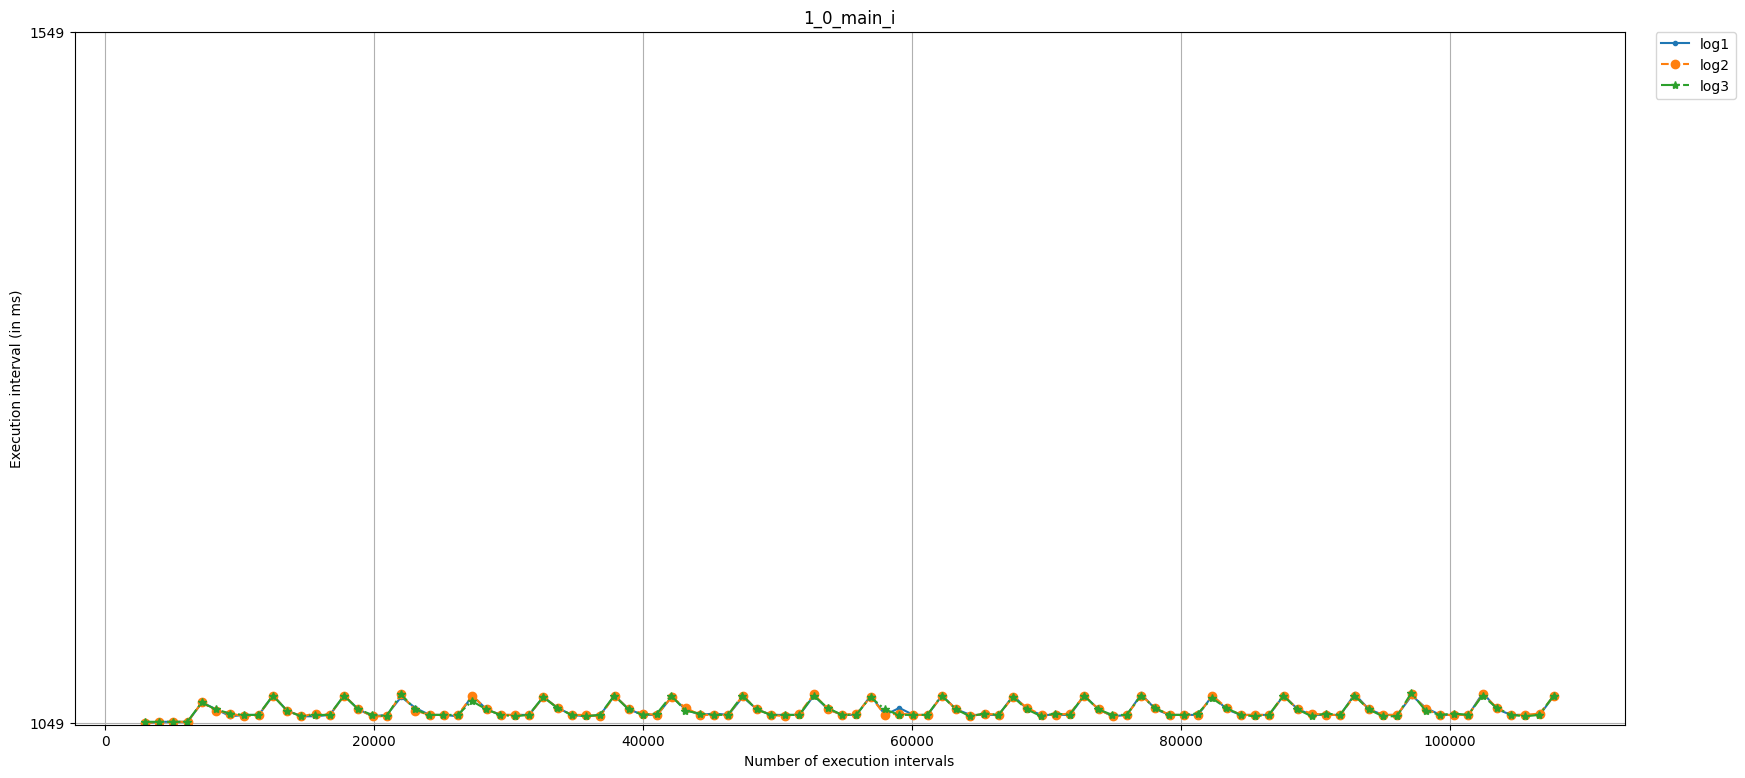

[([], []), ([], []), ([], [])]


<Figure size 2000x900 with 0 Axes>

In [11]:
####### line plot for analysis
import matplotlib.pyplot as plt
import numpy as np

### name represents the name of respective variable with which file will be saved
for (name, log_names, xy_data) in to_plot:
    ### path to save the plots
    to_write_name = name.replace('trace_data', 'exe plots')
    file_name = os.path.basename(to_write_name)
    file_name = f'{thread_typ}_version{version}_{behaviour}_{file_name}'
    dir_name = os.path.dirname(to_write_name)
    to_write_name = os.path.join(dir_name, file_name)
    #print(to_write_name)
    isPath = os.path.exists(os.path.dirname(to_write_name)) ### check if the path exists
    ### create the folder if it does not exist
    if not isPath:
        os.makedirs(os.path.dirname(to_write_name))

    
    ########## make data frame to be able to plot ################
    df = dict()
    _y_all = [] ### to adjust y-ticks
    legend_lab = [] ### collect names of the plots only
    line_style = ['solid', 'dashed', 'dashdot', 'dotted']
    markers = ['.','o','*','+','^','x','d','h',',','H','D']
    fig = plt.figure(figsize =(20, 9))
    print(xy_data)
    for (num, (l,xy)) in enumerate(zip(log_names, xy_data)):
        x = xy[1]
        #x = [i-x[0] for i in x]   ### get timestamps relative to first timestamp
        y = xy[0]
        ### ignore all the variables that are only executed once
        if xy[1]!= []:
            #print(x,y)
            df[l]=xy
            _y_all.extend(y)
            legend_lab.append(l)
            
            plt.plot(x, y, ls=line_style[num%4], marker=markers[num%11])
        
    if _y_all != []:
        plt.legend(legend_lab, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.yticks(np.arange(min(_y_all), max(_y_all)+500, 500)) ### y ticks every 500ms
        plt.xlabel('Number of execution intervals')
        plt.ylabel('Execution interval (in ms)')
        plt.grid(True)
        plt.title(f'{os.path.basename(name)}')
        plt.savefig(f'{to_write_name}.png', bbox_inches='tight')
        plt.show()

    #break


# Event Traces

### Process Traces

In [11]:
########## process the traces ###########
raw_trace = read_traces(paths_traces[0])
to_number, from_number = generate_map(raw_trace)

col_data = []
for (p,w) in zip(paths_traces, traces):
    trace = read_traces(p)
    num_trace = []
    for t in trace:
        nt = to_number[t]
        #print(nt)
        num_trace.extend([nt])
    col_data += [(w, num_trace)]   ### in the format (trace_name, event trace) 


### Generate excel sheet

In [12]:
######### write the data to excel sheet ###########

import xlsxwriter

workbook = xlsxwriter.Workbook(f'{thread_typ}_version{version}_eventtrace_{behaviour}.xlsx')

### add worksheet for mapper
worksheet = workbook.add_worksheet('mapper')

### convert dict to list and write to xls

worksheet.write(0, 0, 'event num')
worksheet.write(0, 1, 'event name')

row = 1
col = 0
keym = list(from_number.keys())
for k in keym:
    val = from_number[k]
    worksheet.write(row, col, k)
    worksheet.write(row, col+1, val)
    row+=1

### add worksheet for traces
worksheet = workbook.add_worksheet('traces')
row = 0
col = 0
for (name, trace) in col_data:
    worksheet.write(row, col, name)
    row+=1
    for t in trace:
        worksheet.write(row, col, t)
        row+=1
    col+=1
    row=0

workbook.close()

In [14]:
### check if all traces are same #######

In [15]:
'''
TODO:
- read SOTA for types of Faults
- Prepare poster for Mamba
- Prepare slides for CN SPace
- German HW
'''

'\nTODO:\n- read SOTA for types of Faults\n- Prepare poster for Mamba\n- Prepare slides for CN SPace\n- German HW\n'